# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA) by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [3]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


Original Images


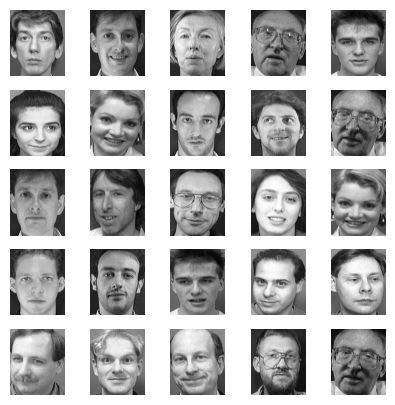

In [12]:
trainFaces = np.array(trainFaces)
trainFaces = trainFaces.reshape((trainFaces.shape[0], 112, 92))

# Visualize the original images
def griddisplay(image_list):
    fig, axes_array = plt.subplots(5, 5)
    fig.set_size_inches(5, 5)
    k = 0
    for row in range(5):
        for col in range(5):
            image_plot = axes_array[row][col].imshow(image_list[k], cmap=plt.cm.gray)
            axes_array[row][col].axis('off')
            k = k + 1
    plt.show()

print('Original Images')
griddisplay(trainFaces)

trainfaces are basically total 360 images each of size 112*92. TrainLabels correspond to the labels of the images.

#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

(360, 10304)
Zero mean faces


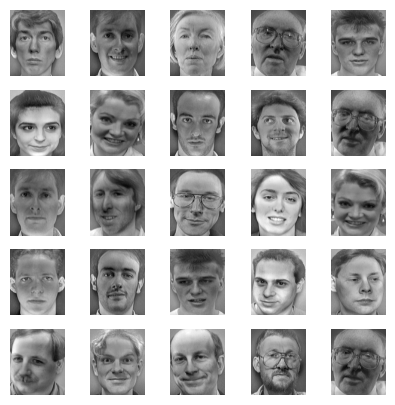

In [25]:
import scipy.misc
import matplotlib.pyplot as plt
flattened_trainFaces=[]
for i in range(trainFaces.shape[0]):
    flattened_trainFaces.append(trainFaces[i].flatten())
flattened_trainFaces = np.array(flattened_trainFaces)
print(flattened_trainFaces.shape)

# Compute the mean face
mean_face = np.mean(flattened_trainFaces, axis=0)

zero_mean=[]
coloumn=0
zero_mean_matrix=np.ones((112*92,360))

for values in flattened_trainFaces:
    zm=values-mean_face
    zm=np.squeeze(zm)
    zero_mean_matrix[:,coloumn]=zm
    zm_image=zm.reshape(112,92)
    zero_mean.append(zm_image)
    coloumn=coloumn+1

print('Zero mean faces')
griddisplay(zero_mean)

(10304, 360)
(360,) (360, 360)
(360,)
Eigenfaces


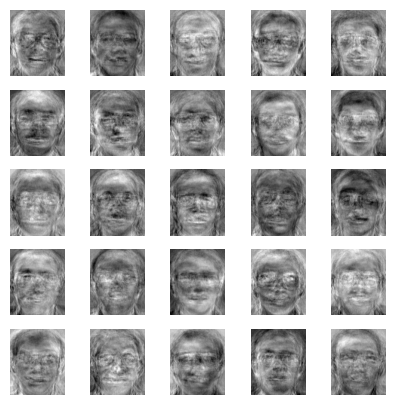

In [33]:
# Compute the covariance matrix
print(zero_mean_matrix.shape)
d = (np.dot(np.transpose(zero_mean_matrix), zero_mean_matrix)) / 360

u_list=[]
eigen_values, eigen_vectors = np.linalg.eig(d)
print(eigen_values.shape, eigen_vectors.shape)
print(eigen_vectors[0].shape)
for ev in eigen_vectors:
    ev_transpose = np.transpose(np.matrix(ev))
    u = np.dot(zero_mean_matrix, ev_transpose)
    u = u / np.linalg.norm(u)
    u_i = u.reshape(112, 92)  # Adjust to the shape of your input data
    u_list.append(u_i)

print('Eigenfaces')
griddisplay(u_list)


In [5]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """


#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [6]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """
  
    # your code here

    return None

In [7]:
# plot recontructions here
%matplotlib inline

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

In [8]:
%matplotlib inline

def displayNfactors():

    # your code here

    return None

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [9]:
def getClass():
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
    """

    # your code here

    return None

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [10]:
components = [3,5,10,20,30,40,50]
mse = []

for numComponents in components:
    # your code here

SyntaxError: incomplete input (1630759355.py, line 5)

Plot Number of eigenvectors vs Mean Square Error

In [ ]:
# your code here

Plot Number of eigenvectors vs Logarithmic Mean Square Error

In [ ]:
# your code here